<h1 style="background-color:orange;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table Of Content</h1>



* [1. Libraires And Utilities](#1)

* [2 Text Preprocessing](#2)

* [3 Vader Sentiment Analysis](#3)
    * [3.1 Feature Engineering](#3.1)


* [4. Exploratory Data Analysis](#4)
    * [4.1 Time Based Analysis](#4.1)
        * [4.1.1 Probabilistic Inference](#4.1.1)
    * [4.2 Extreme Sentiment Analysis](#4.2)
    * [4.3 Sentiment Correlation Analysis](#4.3)
    * [4.4 User Analysis](#4.4)
    * [4.5 Text Decomposition Analysis](#4.5)

* [5. Conclusions](#5)


<a id="1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Libraires And Utilities</h1>


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [2]:
f_data = pd.read_csv('/kaggle/input/pfizer-vaccine-tweets/vaccination_tweets.csv')
f_data.head(3)

id    user_name              user_location  \
0  1340539111971516416   Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433  Albert Fong          San Francisco, CA   
2  1337858199140118533     eli🇱🇹🇪🇺👌                   Your Bed   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   
2                                     heil, hydra 🖐☺  2020-06-25 23:30:28   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   
2              10            88              155          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False

<a id="2"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Text Preprocessing</h1>


In [3]:
#f_data.text =f_data.text.str.lower()

#Remove twitter handlers
f_data.text = f_data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
f_data.text = f_data.text.apply(lambda x:re.sub(r'\B#\S+','',x))


# Remove URLS
f_data.text = f_data.text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
f_data.text = f_data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
f_data.text = f_data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
f_data.text = f_data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


<p style="text-align: center;"><span style='font-size: 24px; font-family: "Times New Roman", Times, serif;'>In the above code cell, we preprocess the text feature of our dataset, which contains the tweet&apos;s body.</span></p>
<p style="text-align: center;"><span style="font-family: 'Times New Roman', Times, serif;"><span style="font-size: 24px;">Our goal is to perform the sentiment analysis on clean text data to avoid noise and misreadings!</span></span></p>
<p style="text-align: center;"><span style='font-size: 24px; font-family: "Times New Roman", Times, serif;'>Remembering the good all saying, garbage in garbage out.</span></p>

<a id="3"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Vader Sentiment Analysis</h1>


In [4]:
sid = SIA()
f_data['sentiments']           = f_data['text'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

f_data.drop(columns=['sentiments'],inplace=True)

<p style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; text-align: center;"><span data-preserver-spaces="true" style='color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; font-family: "Times New Roman", Times, serif; font-size: 24px;'>VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up each word&apos;s intensity in the text.</span></p>
<p style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; text-align: center;"><span style="font-family: 'Times New Roman', Times, serif;"><span style="font-size: 24px;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">For example,- Words like</span><em style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">&nbsp;&apos;love,&apos; &apos;enjoy,&apos; &apos;happy,&apos; &apos;like&apos;&nbsp;</span></em><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">all convey a positive sentiment. Also, VADER is intelligent enough to understand these words&apos; basic context, such as&nbsp;</span><em style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">&quot;did not love&quot;</span></em><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">&nbsp;as a negative statement. It also understands the emphasis of capitalization and punctuation, such as&nbsp;</span><em style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">&quot;ENJOY.&quot;</span></em></span></span></p>
<p style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; text-align: center;"><em style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;"><span data-preserver-spaces="true" style='color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; font-family: "Times New Roman", Times, serif; font-size: 24px;'></span></em></p>
<p><br></p>
<p style="text-align: center;"><span style="font-family: 'Times New Roman', Times, serif;"><br></span></p>
<p style="text-align: center;"><a href="http://%3Cp%3E%3Ca%20href=%22https%3A//towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664#%3A~%3Atext=VADER%20(%20Valence%20Aware%20Dictionary%20for,intensity%20(strength)%20of%20emotion.&text=VADER%20sentimental%20analysis%20relies%20on,intensities%20known%20as%20sentiment%20scores.%22%3Ehttps%3A//towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664#%3A~%3Atext=VADER%20(%20Valence%20Aware%20Dictionary%20for,intensity%20(strength)%20of%20emotion.&text=VADER%20sentimental%20analysis%20relies%20on,intensities%20known%20as%20sentiment%20scores.%3C/a%3E%3C/p%3E%20%3Cp%3E%3Cbr%3E%3C/p%3E"><span style="font-family: 'Times New Roman', Times, serif;">Source</span></a></p>

<a id="3.1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Feature Engineering</h1>


In [5]:
#Number of Words
f_data['Number_Of_Words'] = f_data.text.apply(lambda x:len(x.split(' ')))
#Average Word Length
f_data['Mean_Word_Length'] = f_data.text.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )

<a id="4"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Exploratory Data Analysis</h1>


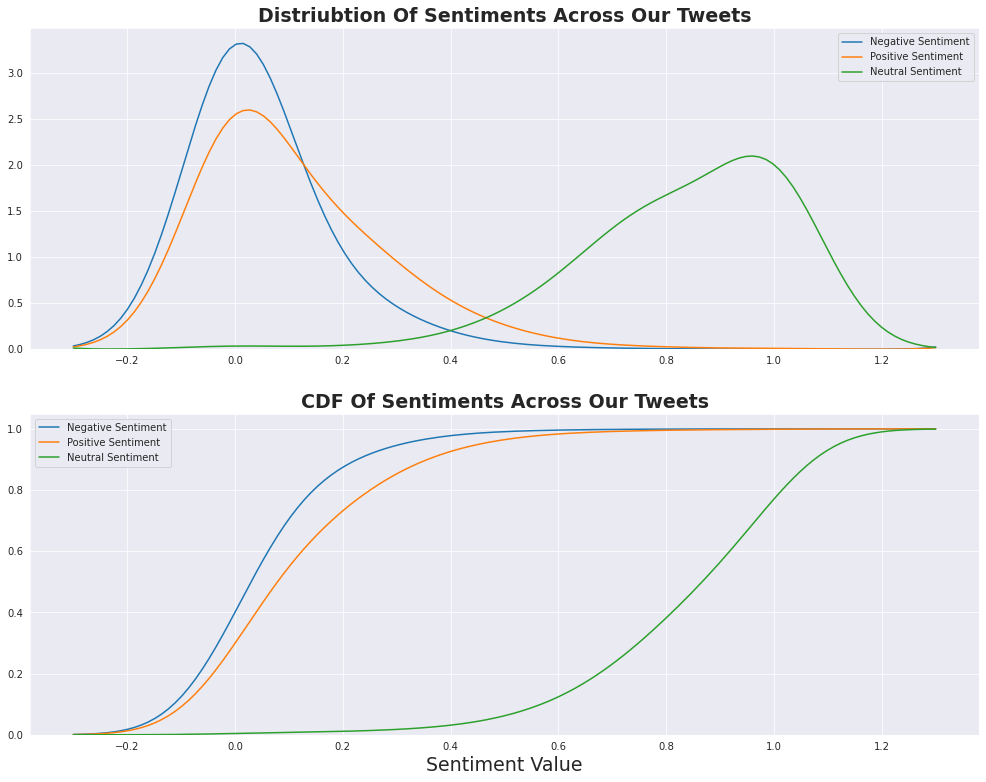

In [6]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>You can observe that the distributions of the sentiments follow a normal distribution; the negative and positive sentiments are very similar, proposing that there may be no significant differences in the strength of our data&apos;s positive and negative sentiments.</span></p>
<p style="text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><br></span></span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>It is also clear that the dominant sentiment is neutral; oddly, most of the tweets do not resemble more positive or negative sentiment rather neutral.</span></p>

<a id="4.1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">Time Based Analysis</h1>


In [7]:
#Sorting And Feature Engineering
f_data = f_data.sort_values(by='date')
ft_data=f_data.copy()
ft_data['date'] = pd.to_datetime(f_data['date']).dt.date

ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

In [8]:
f_data=f_data.reset_index().drop(columns=['index'])
partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])



neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)

In [9]:
fig = make_subplots(rows=3, cols=2)

for idx,prt in enumerate(partitions):
    fig.add_trace(
    go.Scatter(x=prt['date'], y=prt['Positive Sentiment'],name=f'Positive Part {idx+1}'),
    row=idx+1, col=1)
    fig.add_trace(
    go.Scatter(x=prt['date'], y=prt['Negative Sentiment'],name=f'Negative Part {idx+1}'),
    row=idx+1, col=2)

fig.update_layout(height=600, width=900, title_text="Distibution Of Daily Sentiments Over Our Time Line For Each Partition")
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We see that the tweets' sentiments do not meet stationarity requirements as to non-constant mean and variance.
In the above code cell, we have tested our hypothesis on 3 partitions of our data.
Might it indicate we have some trend in our data?</span></p>
<p><br></p>

In [10]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()

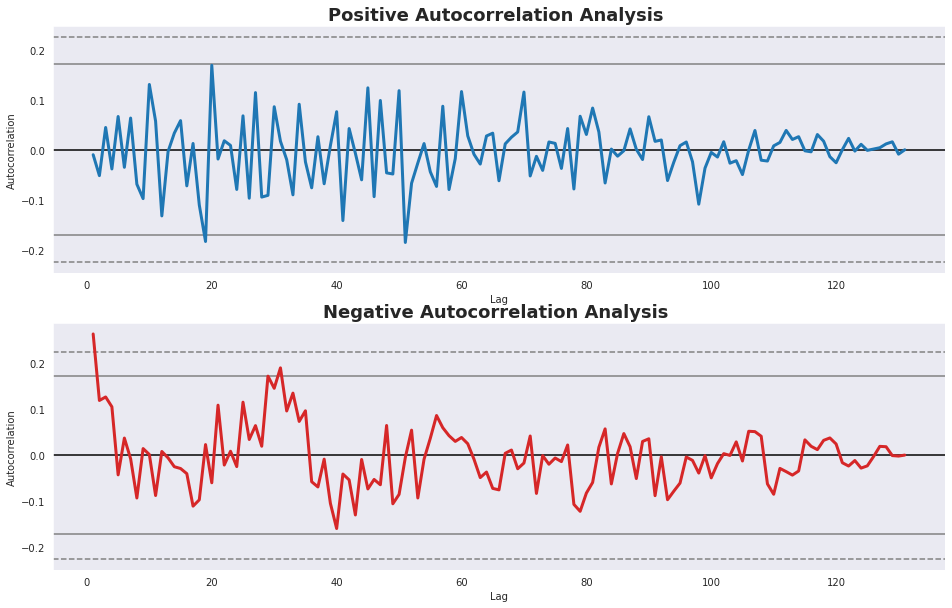

In [11]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()

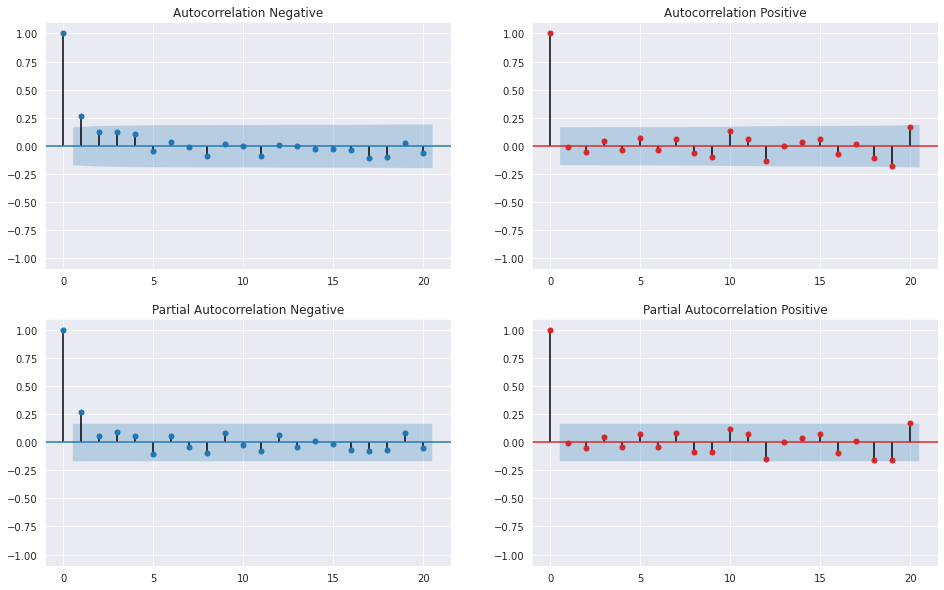

In [12]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
ax[0,0].set_ylim(-1.1,1.1)
ax[1,0].set_ylim(-1.1,1.1)
ax[0,1].set_ylim(-1.1,1.1)
ax[1,1].set_ylim(-1.1,1.1)

plot_acf(b_date_mean['Negative Sentiment'],lags=20, ax=ax[0,0],title='Autocorrelation Negative')
plot_pacf(b_date_mean['Negative Sentiment'],lags=20, ax=ax[1,0],title='Partial Autocorrelation Negative')
plot_acf(b_date_mean['Positive Sentiment'],lags=20, ax=ax[0,1],color='tab:red',title='Autocorrelation Positive')
plot_pacf(b_date_mean['Positive Sentiment'],lags=20, ax=ax[1,1],color='tab:red',title='Partial Autocorrelation Positive')
plt.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>From the ACR and PACR plots above, it is clear that there is no significant correlation between sentiments lagged by x units.</span></p>
<p><br></p>

In [13]:
b_date_mean = ft_data.groupby(by='date').mean().reset_index()
b_date_std = ft_data.groupby(by='date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)

fig.add_annotation(x=b_date_mean['date'].values[3], y=b_date_mean['Positive Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Positive Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10)



fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)

fig.add_annotation(x=b_date_mean['date'].values[3], y=b_date_mean['Negative Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Negative Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10,
            xref='x2', 
            yref='y2')



fig.add_annotation(x=b_date_mean['date'].values[5], y=b_date_mean['Negative Sentiment'].mean()+0.01,
            text=r"Start Of Decline",
            showarrow=True,
            arrowhead=6,
            yshift=10,
            xref='x2', 
            yref='y2')

fig.add_annotation(x=b_date_mean['date'].values[15], y=.024,
            text=r"Start Of Incline",
            showarrow=True,
            arrowhead=6,
            yshift=10,
            xref='x2', 
            yref='y2')

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>One observation that interests me the most is that from the 20 of December to the 27 of December, there is a decline in the strength of the average negative sentiment; what happened in that week that induced this decline?</span></p>
<p><br></p>

<p style="text-align: center;"><strong><span style='font-family: "Times New Roman", Times, serif; font-size: 26px;'>What Happened On The 17th December</span></strong></p>
<a href="https://ibb.co/rxZWpbz"><img src="https://i.ibb.co/Pc5SWTP/Screenshot-2021-01-09-202708.png" alt="Screenshot-2021-01-09-202708" border="0"></a>

<p style="text-align: center;"><strong><span style='font-family: "Times New Roman", Times, serif; font-size: 26px;'>Possible Explanation For The Incline On The 27th</span></strong></p>

<a href="https://ibb.co/PmzJrvX"><img src="https://i.ibb.co/YRTJNFn/Screenshot-2021-01-08-120838.png" alt="Screenshot-2021-01-08-120838" border="0"></a>

In [14]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Deviation in Positive Sentiment',  'Daily Deviation in Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_std['date'], y=b_date_std['Positive Sentiment'],name='Positive Sentiment SD'),
    row=1, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['date'].values[0], y0=b_date_std['Negative Sentiment'].mean(), x1=b_date_std['date'].values[-1], y1=b_date_std['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['date'].values[0], y0=b_date_std['Positive Sentiment'].mean(), x1=b_date_std['date'].values[-1], y1=b_date_std['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x1', 
        yref='y1'
)


fig.add_trace(
    go.Scatter(x=b_date_std['date'], y=b_date_std['Negative Sentiment'],name='Negative Sentiment SD'),
    row=2, col=1
)

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Deviation Change With Time")
fig.show()


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>The daily standard deviation of the positive and negative sentiments becomes less stable after the 27, which further increases the question&apos;s interest, what happened on the 27?</span></p>
<p><br></p>

In [15]:
import datetime
b_date_count = ft_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'id':'Tweets Per Day'})
fig = ex.line(b_date_count,x='date',y='Tweets Per Day')

# fig.add_annotation(x=b_date_mean['date'].values[15], y=.024,
#             text=r"Start Of Incline",
#             showarrow=True,
#             arrowhead=6,
#             yshift=10)


fig.add_shape(type="line",
    x0=b_date_count['date'].values[0], y0=b_date_count['Negative Sentiment'].mean(), x1=b_date_count['date'].values[-1], y1=b_date_count['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
)

fig.update_traces(mode="markers+lines")
fig.update_layout(hovermode="x unified")


###annots
b_date_count.date = pd.to_datetime(b_date_count.date)
b_date_count_dt = b_date_count.set_index('date')
fig.add_annotation(x=datetime.datetime(2021,2,19), y=b_date_count_dt.loc[pd.Timestamp('2021-02-19'),'year'],
            text=r"Israeli study finds Pfizer vaccine 85% effective after first shot",
            showarrow=True,
            arrowhead=3,
            yshift=5,bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,1,29), y=b_date_count_dt.loc[pd.Timestamp('2021-01-29'),'year'],
            text=r"vaccine found to be effective against variant discovered in U.K.",
            showarrow=True,
            arrowhead=3,
            yshift=5,ay=-160,bordercolor="#c7c7c7")
fig.add_annotation(x=datetime.datetime(2021,1,8), y=b_date_count_dt.loc[pd.Timestamp('2021-01-8'),'year'],
            text=r"Commission proposes to purchase up to 300 million additional doses of BioNTech-Pfizer vaccine",
            showarrow=True,
            arrowhead=3,
            yshift=5,ay=-30,bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,1,20), y=b_date_count_dt.loc[pd.Timestamp('2021-01-20'),'year'],
            text=r"The presidency of Joe Biden began",
            showarrow=True,
            arrowhead=3,
            yshift=3,ay=120,bordercolor="#c7c7c7")

fig.update_layout(title='<b>Daily Tweet Count<b>',width=1200)
fig.show()

<a id="4.1.1"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">Probabilistic Inference</h1>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Denoting day $i$'s  count by $C_i$,
    $$ C_i \sim \text{Poisson}(\lambda)  $$ We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the count plot above, it appears that the rate might become lower late in the observation period (with every day new data is being added), which is equivalent to saying that $\lambda$ increases at some point during the observations. Let's assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly drops to a lower value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. we define our switchpoint as:
$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$ If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal. \begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}  What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible day. This is equivalent to saying
\begin{align}
& \tau \sim \text{DiscreteUniform(1,NumberOfDays) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{NumberOfDays}
\end{align}</span></p>


In [16]:
import pymc3 as pm

with pm.Model():
    alpha = 1/(b_date_count['Tweets Per Day'].mean())
    LAMBDA1  = pm.Exponential('lambda1',alpha)
    LAMBDA2  = pm.Exponential('lambda2',alpha)

    tau = pm.DiscreteUniform('tau',lower=0,upper=len(b_date_count)-1)
    
    idx = np.arange(len(b_date_count))
    LAMBDA_ = pm.math.switch(tau>idx,LAMBDA1,LAMBDA2)
    
    obs = pm.Poisson('obs',LAMBDA_,observed=b_date_count['Tweets Per Day'])
    
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning:

In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.



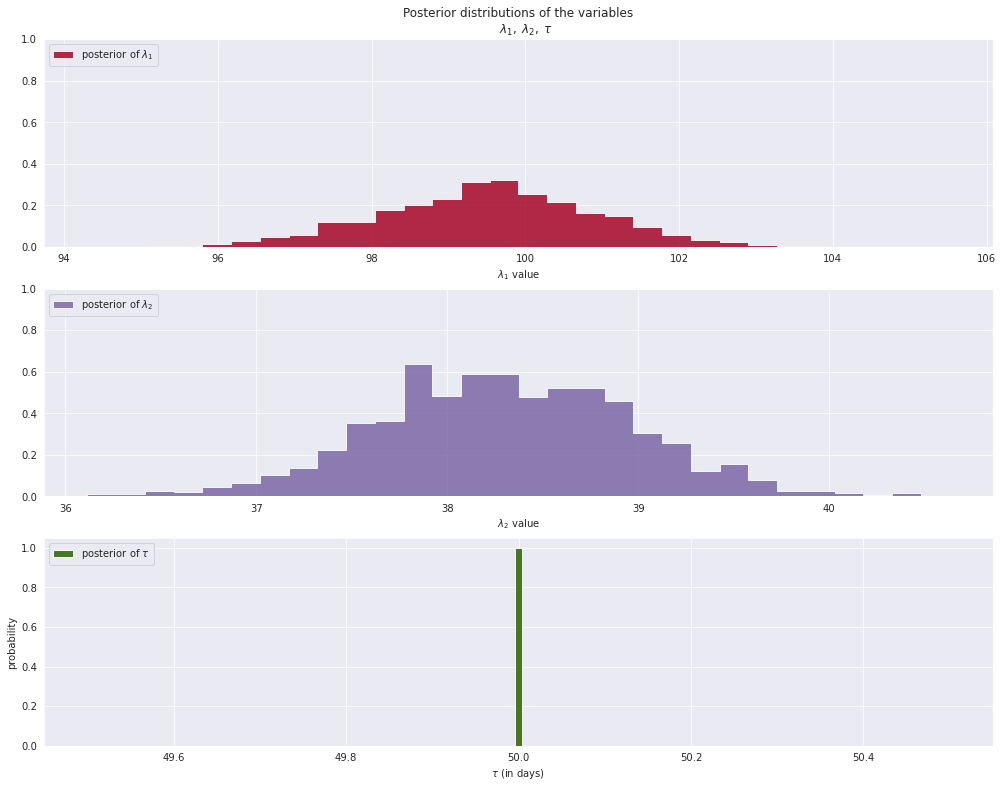

In [17]:
#histogram of the samples:
lambda_1_samples = trace['lambda1'][10000:]
lambda_2_samples = trace['lambda2'][10000:]
tau_samples = trace['tau'][10000:]
n_count_data = len(b_date_count)
count_data = b_date_count['Tweets Per Day']
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)

plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'> What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 99 and $\lambda_2$ is around 43-44. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour with strong confidence at day 50 i.e 31 of January which is visually the first suspect.</span></p>
<p><br></p>


<a id="4.2"></a>
<h1 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">Extreme Sentiment Analysis</h1>


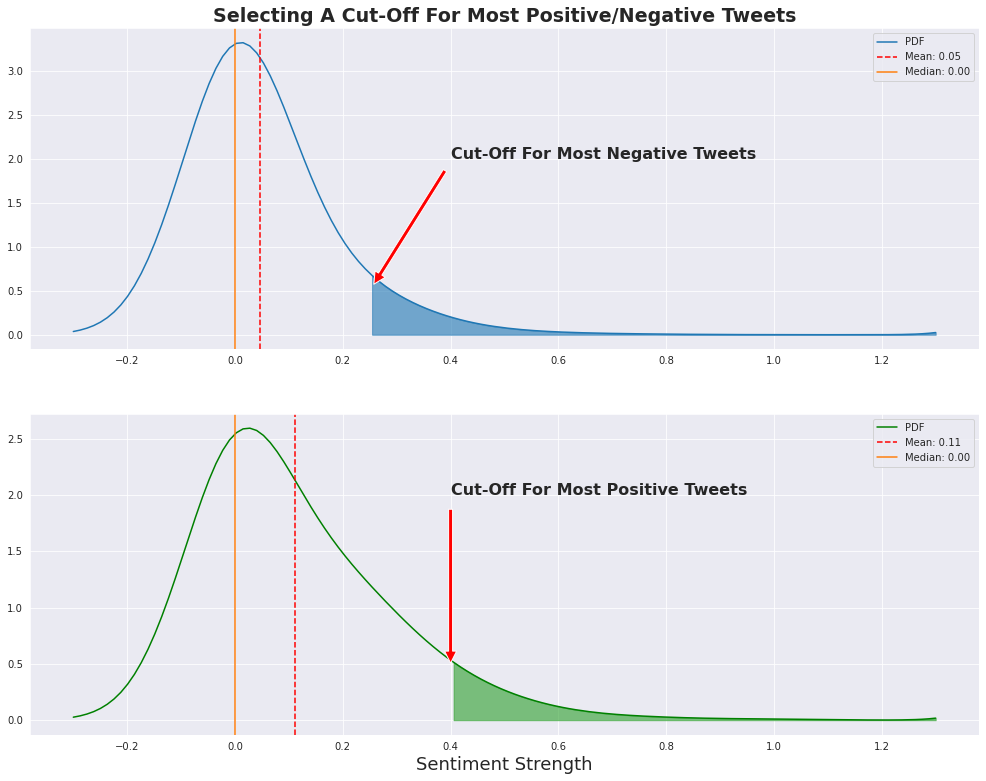

In [18]:
plt.subplot(2,1,1)
plt.title('Selecting A Cut-Off For Most Positive/Negative Tweets',fontsize=19,fontweight='bold')

ax0 = sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)

kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=(kde_x>0.25) , 
                interpolate=True, color='tab:blue',alpha=0.6)

plt.annotate('Cut-Off For Most Negative Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')

ax0.axvline(f_data['Negative Sentiment'].mean(), color='r', linestyle='--')
ax0.axvline(f_data['Negative Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Negative Sentiment'],r'Mean: {:.2f}'.format(f_data['Negative Sentiment'].mean()):f_data['Negative Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Negative Sentiment'].median()):f_data['Negative Sentiment'].median()})

plt.subplot(2,1,2)

ax1 = sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,color='green')

plt.annotate('Cut-Off For Most Positive Tweets', xy=(0.4, 0.43), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=(kde_x>0.4) , 
                interpolate=True, color='tab:green',alpha=0.6)
ax1.set_xlabel('Sentiment Strength',fontsize=18)


ax1.axvline(f_data['Positive Sentiment'].mean(), color='r', linestyle='--')
ax1.axvline(f_data['Positive Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Positive Sentiment'],r'Mean: {:.2f}'.format(f_data['Positive Sentiment'].mean()):f_data['Positive Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Positive Sentiment'].median()):f_data['Positive Sentiment'].median()})

plt.show()

In [19]:
Most_Positive = f_data[f_data['Positive Sentiment'].between(0.4,1)]
Most_Negative = f_data[f_data['Negative Sentiment'].between(0.25,1)]

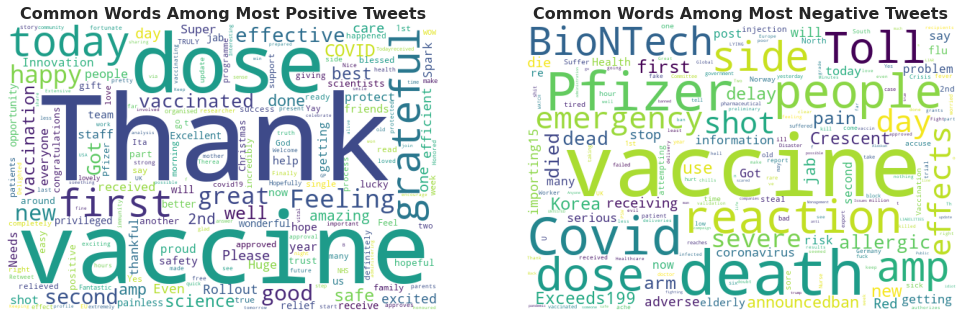

In [20]:
Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

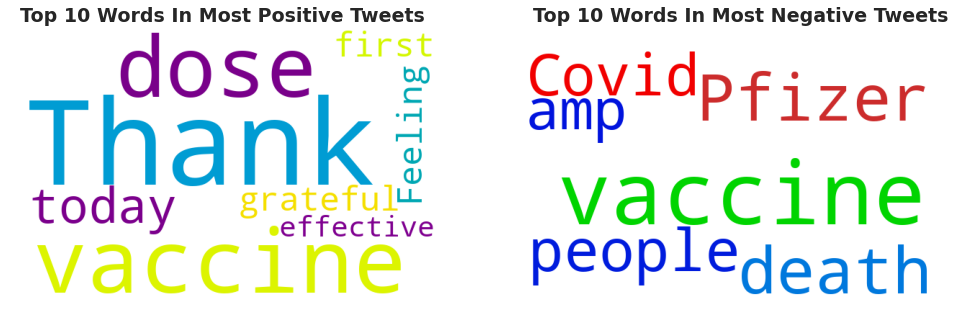

In [21]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:10]
top_10_neg = list(w2_dict.keys())[:10]

plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()

In [22]:

token=nltk.word_tokenize(' '.join(f_data.text))
pos_bigram=ngrams(token,2)
pos_bigram_dict = dict()
pos_trigram =ngrams(token,3)
pos_trigram = [k for k in pos_trigram if k[0] in top_10_pos]

token=nltk.word_tokenize(' '.join(f_data.text))
neg_bigram=ngrams(token,2)
neg_bigram_dict = dict()
neg_trigram =ngrams(token,3)
neg_trigram = [k for k in neg_trigram if k[0] in top_10_neg]

for i in neg_bigram:
    neg_bigram_dict[i] = neg_bigram_dict.get(i,0)+1
for i in pos_bigram:
    pos_bigram_dict[i] = pos_bigram_dict.get(i,0)+1
        
pos_trigram_dict = dict()
neg_trigram_dict = dict()

for i in pos_trigram:
    pos_trigram_dict[i] = pos_trigram_dict.get(i,0)+1
    
for i in neg_trigram:
    neg_trigram_dict[i] = neg_trigram_dict.get(i,0)+1
 

pos_trigram_df = pd.DataFrame(random.sample(list(pos_trigram_dict.keys()),k=15),columns=['One Of Top 10 Words','Second Word','Third Word'])

def get_prob(sir):
    key = (sir['One Of Top 10 Words'],sir['Second Word'],sir['Third Word'])
    w3 = pos_trigram_dict[key]
    w2 = pos_bigram_dict[(sir['One Of Top 10 Words'],sir['Second Word'])]
    return w3/w2

pos_trigram_df['Probabilty Of Sentence'] = pos_trigram_df.apply(get_prob,axis=1)

pos_trigram_df.style.background_gradient(subset='Probabilty Of Sentence',cmap='vlag')

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Above is a trigram of 15 sentences that start with one of the top 10 positive tweet words and the probability that the sentence will appear in random 'extremly' negative tweet.</span></p>
<p><br></p>

In [23]:
neg_trigram_df = pd.DataFrame(random.sample(list(neg_trigram_dict.keys()),k=15),columns=['One Of Top 10 Words','Second Word','Third Word'])

def get_prob(sir):
    key = (sir['One Of Top 10 Words'],sir['Second Word'],sir['Third Word'])
    w3 = neg_trigram_dict[key]
    w2 = neg_bigram_dict[(sir['One Of Top 10 Words'],sir['Second Word'])]
    return w3/w2

neg_trigram_df['Probabilty Of Sentence'] = neg_trigram_df.apply(get_prob,axis=1)

neg_trigram_df.style.background_gradient(subset='Probabilty Of Sentence',cmap='vlag')

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Above is a trigram of 15 sentences that start with one of the top 10 negative tweet words and the probability that the sentence will appear in random 'extremly' negative tweet.</span></p>
<p><br></p>

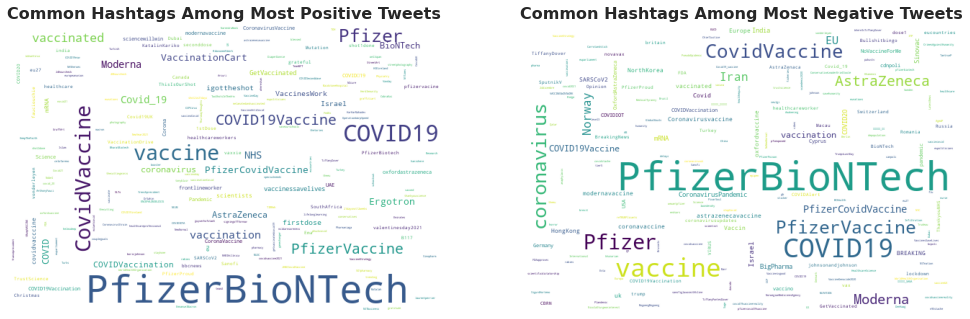

In [24]:
Most_Positive_ht = ' '.join(Most_Positive[Most_Positive.hashtags.notna()].hashtags)
Most_Negative_ht = ' '.join(Most_Negative[Most_Negative.hashtags.notna()].hashtags)

Most_Positive_ht = re.sub(r'\W', ' ', Most_Positive_ht)
Most_Negative_ht = re.sub(r'\W', ' ', Most_Negative_ht)
Most_Positive_ht = re.sub(r'\s+', ' ', Most_Positive_ht, flags=re.I)
Most_Negative_ht = re.sub(r'\s+', ' ', Most_Negative_ht, flags=re.I)

pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_ht)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_ht)

plt.subplot(1,2,1)
plt.title('Common Hashtags Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Hashtags Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

In [25]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Top 10 Most Positive Locations Contributes',  'Top 10 Most Negative Locations Contributes'))

fig.add_trace(
    go.Bar(x=Most_Positive.user_location.value_counts()[:10].index, y=Most_Positive.user_location.value_counts()[:10].values,name='Number Of Tweets'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=Most_Negative.user_location.value_counts()[:10].index, y=Most_Negative.user_location.value_counts()[:10].values,name='Number Of Tweets'),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>London and Miami are the leading locations when looking at the tweets we took from our positive cut-off in contrast to Moronto City, which stands out in the most negative cut-off.</span></p>
<p><br></p>

<a id="4.3"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">Correlation Analysis</h1>


In [26]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data[['user_followers','user_friends','user_favourites','user_verified','Positive Sentiment','Neutral Sentiment','Negative Sentiment']].corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data[['user_followers','user_friends','user_favourites','user_verified','Positive Sentiment','Neutral Sentiment','Negative Sentiment']].corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>Unfortunately, we see no significant correlation between the tweet sentiments and any other numeric features given in our dataset, especially those that describe users.</span></p>

<a id="4.4"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">User Analysis</h1>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>This section of our analysis will define a new metric representing a user&apos;s popularity; we will define a formula that will output a score of popularity based on the user follower, friend, and favorite counts.</span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>The new metric will allow us to analyze the different users and the contribution to the average sentiments by different groups of user popularity.</span></p>
<p><br></p>


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We will define user popularity using the following formula; $$ \Theta = \begin{Bmatrix}1\textrm{ if user is verified}\\\textrm{else }0.5\end{Bmatrix} $$ $$\textrm{Popularity:}\rho  = \sqrt{0.65*\textrm{User Followers}+0.25*\textrm{User Friends}+0.10*\textrm{User Favourites}}* \Theta $$</span></p>
<p><br></p>

In [27]:
def user_popularity(sir):
    teta = 0
    if sir['user_verified'] == 'True':
        teta=1
    else:
        teta=0.5
    rho = np.sqrt(sir['user_followers']*0.65+sir['user_friends']*0.25+sir['user_favourites']*0.10)*teta
    return np.round(rho)

f_data['user_popularity'] = f_data.apply(user_popularity,axis=1)

In [28]:
user_df = f_data.groupby(by='user_name').mean().reset_index()
user_df[['user_name','user_popularity','Positive Sentiment','Negative Sentiment']].sample(5)

user_name  user_popularity  \
4902                                         gohchoonfu             10.0   
3844                                       Sam Stitches             44.0   
2640  LyrynxAyla Ex-Labour, Anti da zionistTory-lite...             12.0   
4168                                  Stuart McAllister            154.0   
1542                                  French Healthcare             28.0   

      Positive Sentiment  Negative Sentiment  
4902            0.000001            0.000001  
3844            0.202001            0.000001  
2640            0.000001            0.217001  
4168            0.470001            0.000001  
1542            0.000001            0.000001

<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>The dataset was grouped by the user names, and the average value of each feature was calculated.
    Next, we will divide our dataset into 5 categories of popularity, where 1 is a user who has a very low popularity score compared to others, and 5 is prevalent and influential.</span></p>
<p><br></p>

In [29]:
KM = KMeans(5,random_state=42)
C_DF = user_df[['user_popularity']].copy()
C_DF.user_popularity = (C_DF.user_popularity-C_DF.user_popularity.mean())/C_DF.user_popularity.std()
#C_DF.Mean_Word_Length = (C_DF.Mean_Word_Length-C_DF.Mean_Word_Length.mean())/C_DF.Mean_Word_Length.std()

KM.fit(C_DF)
p_df = pd.DataFrame({'X':user_df['user_popularity'],'Y':user_df['Mean_Word_Length'],'Z':user_df['Number_Of_Words'],'C':KM.labels_})
ex.scatter_3d(p_df,x='X',y='Y',z='Z',color='C',title='Clustering Users By Popularity')

In [30]:



user_df["Popularity"] = KM.labels_
rg = list(user_df["Popularity"].value_counts().index)

user_df["Popularity"]  = user_df["Popularity"].replace({rg[0]:'Less Than Average',rg[1]:'Average',rg[2]:'Popular',rg[3]:'Very Popular',rg[4]:'Superstar'})

pop_df = user_df.groupby(by='Popularity').mean().reset_index()


fig = make_subplots(rows=2, cols=2,shared_xaxes=True,subplot_titles=('Average Positive Sentiment For Each Category','Proportion Of Different Statuses',  'Average Negative Sentiment For Each Category'),
                   specs=[[{"type": "bar"},{'type':'pie','rowspan':2}],
                           [{"type": "bar"},None]
                         ])

fig.add_trace(
    go.Bar(x=pop_df.Popularity, y=pop_df['Positive Sentiment'],name='Positive Sentiment'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=pop_df.Popularity, y=pop_df['Negative Sentiment'],name='Negative Sentiment'),
    row=2, col=1
)
fig.add_trace(
    go.Pie(values=user_df.Popularity.value_counts().values, labels=user_df.Popularity.value_counts().index,name='Proportion Of Different Statuses',hole=0.3,
          marker_colors=ex.colors.diverging.BrBG),
    row=1, col=2
)

fig.update_layout(height=700, width=900, title_text="Different Popularity Categories Average Sentiment Strength")
fig.update_yaxes(title_text="Mean Sentiment")
fig.show()


<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>We observe that the most popular Twitter users tend to be more extreme towards positivity and negativity in their tweets.</span></p>
<p style="text-align: center;"><span style='font-family: "Times New Roman", Times, serif; font-size: 24px;'>And as to the regular, not popular users, they tend to be more positive on average in their tweet sentiment.</span></p>
<p><br></p>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:180%;text-align:center;border-radius: 15px 50px;">Overview on User Analysis</h1>


In [31]:
b_date_mean = f_data.copy()
b_date_mean['user_created'] = pd.to_datetime(b_date_mean['user_created']).dt.normalize().dt.year
b_date_mean = b_date_mean.groupby(by='user_created').mean().reset_index()


ex.line(b_date_mean,x='user_created',y='user_popularity')

fig = go.Figure()

for column in ['user_popularity','user_followers','user_friends','user_favourites','Positive Sentiment','Negative Sentiment']:
    fig.add_trace(
        go.Scatter(
            x = b_date_mean.user_created,
            y = b_date_mean[column],
            name = column,
            mode='lines'
        )
    )
    

btns = []
for x,col in enumerate(['user_popularity','user_followers','user_friends','user_favourites','Positive Sentiment','Negative Sentiment']):
    bol = [False]*12
    bol[x]=True
    d = dict(label = col,
                  method = 'update',
                  args = [{'visible':bol},
                          {'title': 'Distribution of [' +col+'] Over The Years',
                           'showlegend':True}])
    btns.append(d)
    
    
fig.update_layout(title='User Creation Year Effect On Different Aspects',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        showactive=True,
        buttons=btns
        )
    ])

fig.update_xaxes(title_text='User Creation Year')
fig.update_yaxes(title_text='Yearly Mean Value')

fig.show()

In [32]:
user_df=user_df.sort_values(by='user_popularity',ascending=False)
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}],
           [{"type": "scatter"}]]
)

fig.add_trace(
    go.Scatter(
        x=user_df["user_popularity"],
        y=user_df["Positive Sentiment"],
        mode="markers",
        name="Positive Sentiment"
    ),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=user_df["user_popularity"],
        y=user_df["Negative Sentiment"],
        mode="markers",
        name="Negative Sentiment"
    ),
    row=3, col=1
)

fig.add_trace(
    go.Table(
        header=dict(
            values=['<b>user_name<b>',"<b>Popularity<b>",'<b>Negative Sentiment<b>','<b>Positive Sentiment<b>'],
            font=dict(size=19,family="Lato"),
            align="center"
        ),
        cells=dict(
            values=[user_df[k].tolist() for k in ['user_name',"user_popularity",'Negative Sentiment','Positive Sentiment']],
            align = "center", font=dict(size=12)),
    ),
    row=1, col=1
)

figg = ex.scatter(user_df, x='user_popularity', y='Positive Sentiment', trendline='ols')
trendline = figg.data[1]
fig.add_trace(trendline)
figg = ex.scatter(user_df, x='user_popularity', y='Negative Sentiment', trendline='ols', color_discrete_sequence=['red'])
trendline = figg.data[1]
fig.add_trace(trendline,3,1)

fig.update_layout(
    height=800,
    showlegend=False,
    title_text="Positive And Negative Sentiment Strength Relationship With Popularity",
)
fig.update_yaxes(title_text="Sentiment Strength")
fig.show()

<a id="4.5"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Text Decomposition Analysis</h1>


In [33]:
NUMBER_OF_COMPONENTS = 450

CVZ = CountVectorizer()
SVD = TruncatedSVD(NUMBER_OF_COMPONENTS)

text_data = f_data.text.copy()
text_data = text_data.apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS and len(word) > 1]).strip())

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

text_data = text_data.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
text_data = text_data.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

C_vector = CVZ.fit_transform(text_data)


pc_matrix = SVD.fit_transform(C_vector)

evr = SVD.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar", 
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(     title='{:.2f}% of the Tweet Text Variance Can Be Explained Using {} Words'.format(np.sum(evr)*100,NUMBER_OF_COMPONENTS))
fig.show()


<p style="text-align: center;"><strong><span style='font-family: "Times New Roman", Times, serif; font-size: 28px;'>The total variance contribution of different words that make up our reduced dimension.</span></strong></p>

In [34]:
best_fearures = [[CVZ.get_feature_names()[i],SVD.components_[0][i]] for i in SVD.components_[0].argsort()[::-1]]
worddf = pd.DataFrame(np.array(best_fearures[:450])[:,0]).rename(columns={0:'Word'})
worddf['Explained Variance'] =  np.round(evr*100,2)
worddf['Explained Variance'] =worddf['Explained Variance'].apply(lambda x:str(x)+'%')
app = []
for word in worddf.Word:
    total_count = 0
    for tweet in text_data:
        if tweet.find(word)!= -1:
            total_count+=1
    app.append(total_count)
worddf['Appeared_On_X_Tweets'] = app
worddf

fig = go.Figure()
fig.add_trace(
    go.Table(
        header=dict(
            values=['<b>Word<b>',"<b>Explaines X% of Variance<b>",'<b>Appeared On X Tweets<b>'],
            font=dict(size=19,family="Lato"),
            align="center"
        ),
        cells=dict(
            values=[worddf[k].tolist() for k in ['Word',"Explained Variance",'Appeared_On_X_Tweets']],
            align = "center")
    ),
    
)

fig.show()

<a id="5"></a>

<h1 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;">Conclusions</h1>




<p style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; text-align: center;"><span data-preserver-spaces="true" style='color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; font-family: "Times New Roman", Times, serif; font-size: 24px;'>Based on the sentiment analysis done, we learned that;</span></p>
<ul style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">The dominant sentiment of Pfizer vaccine-related tweets is neutral.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">The tweets tend to be more positive than negative on average.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">The sentiment data is not stationary and does not correlate over lagged time periods, thus meaning we cannot forecast how people will feel about the vaccine with the current data.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">There was a trend of decreasing negative sentiment strength from the 13th of December to the 27th, which was when the EU started vaccination.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">The positive sentiments&apos; deviation is more stable than the negative sentiment, which is much less stable. In other words, the strength of the positivity in people&apos;s tweets tends to be more or less the same, unlike the negative strength.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">There are recurring words both in the extremely negative and extremely positive tweets. We got a general idea of the sentences formed in those groups by creating a trigram table with different sentences&apos; probabilities.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">Some locations tend to be more negative/positive than others on average.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">There is no significant correlation between the sentiment and other numeric features provided in the dataset.</span></span></span></li>
    <li style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; list-style-type: disc; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><span data-preserver-spaces="true" style="color: rgb(14, 16, 26); background: transparent; margin-top:0pt; margin-bottom:0pt;">On average, the most popular users tend to be the most extreme as to the sentiment strength in their tweets, both positive and negative.</span></span></span></li>
</ul>
<p style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; text-align: center;"><span style="font-size: 24px;"><span style="font-family: 'Times New Roman', Times, serif;"><br></span></span></p>
<p style="color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; text-align: center;"><span data-preserver-spaces="true" style='color: rgb(14, 16, 26); background: transparent; margin-top: 0pt; margin-bottom: 0pt; font-family: "Times New Roman", Times, serif; font-size: 24px;'>The sentiment strength of a tweet offers us a domain from which we can learn how the population is reacting to the vaccine; such insight can allow the different government to channel their advertisements towards more negative groups that usually refuse to believe in the integrity of the vaccine and observing the change over time similarly as we saw between the 13th and 27th of December.</span></p>